![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)
#### Mount Google Drive

**Carlos González Gamella** 2023-2024

**100364132**

In [3]:
# If you want to store some models or results into your drive, you might find these lines of code useful
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change to assignment directory ('ATVAIV/LabSession3' by default)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATVIAV')

Mounted at /content/drive


#### Required libraries for the lab session

In [4]:
# Numpy
import numpy  as np

# Matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

# Copy
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F  # useful stateless functions
import torch.optim as optim

import torchvision
from torchvision.models import list_models

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.io import read_image

# Grad-CAM
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# SHAP
!pip install shap
import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38244 sha256=43f24958527103b0950ff106dd9c6e87d384596db41b24286d42216a46462ccf
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.5 MB/s eta 0:00:00
cuda


## [!] INSTRUCTIONS FOR THE SUBMISSION OF THE LAB EXERCISES

The objective of this activity is that students strengthen the concepts acquired about **Sustainable and Explainable Artificial Intelligence (SAI and XAI)** for audiovisual processing applications. In this case, the lab exercise is focused on the **Image Classification** task.

In order to do the lab session exercises, students have to use Google Colab, execute this notebook for their resolution and answer several brief questions, including both extra code and text cells, if necessary.

**This notebook with the solutions to the lab exercises must be submitted to Aula Global before the 29th November at 23:59h.**


# LAB SESSION 3
---

# SUSTAINABLE AND EXPLAINABLE ARTIFICIAL INTELLIGENCE (SAI AND XAI) FOR IMAGE CLASSIFICATION

### APPLICATIONS OF SPEECH, AUDIO, IMAGE AND VIDEO PROCESSING

### MASTER IN TELECOMMUNICATIONS ENGINEERING
### ACADEMIC COURSE 2023/2024



1. INTRODUCTION AND OBJECTIVES

2. DATABASE

> 2.1. LOAD DATA

PART 1. SUSTAINABLE ARTIFICIAL INTELLIGENCE (SAI)

3. TRAINING MODEL FROM SCRATCH

4. STANDALONE CLASSIFIER

> 4.1. SELECTION OF THE INITIAL PRE-TRAINED MODEL

> 4.2. INITIALIZATION OF THE PRE-TRAINED MODEL

> 4.3 USE OF THE PRE-TRAINED MODEL AS A STANDALONE CLASSIFIER

5. TRANSFER LEARING

> 5.1. SELECTION OF THE INITIAL PRE-TRAINED MODEL

> 5.2. USE OF THE PRE-TRAINED MODEL AS FEATURE EXTRACTOR

> 5.3. TRANSFER LEARNING

PART 2. EXPLAINABLE ARTIFICIAL INTELLIGENCE (XAI)

6. GRAD-CAM

7. SHAP


---
## 1. INTRODUCTION AND OBJECTIVES
---

This Lab Session makes an introduction to several techniques for Sustainable and Explainable Artificial Intelligence (SAI and XAI).

In the case of **SAI**, we will deal with the application of **transfer learning** for a multiclass image classification problem.

In the case of **XAI**, we will use **Grad-CAM** and **SHAP** techiques for interpreting the predictions made by a deep-learning vision model.



---
## 2. DATABASE
---

The dataset is contained in the .zip file `"insects_data.zip"` that is available in Aula Global. It consists of 813 images of different sizes in 3 classes (*bettles*, *cockroach* and *dragonflies*) with a total of 271 images per class. The data is divided into four subsets:

*   Training set: 450 images
*   Validation set: 180 images
*   Test set: 180 images
*   Test set for XAI: 3 images








---
#### 2.1. LOAD DATA
---

First, we load the dataset. In this case, each image is resized to 224x224 pixels. In addition, a batch size of `64` images is used.

In [5]:
# ----------------------------------
# Load the dataset
# ----------------------------------
# Set batch size
BATCH_SIZE = 64

# Set transformation for training, validation and test images
transform_images = T.Compose([
                T.Resize(size = (224, 224)),
                T.ToTensor()
                ])

# Training data and training data loader
TRAIN_DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/train"
train_dataset = dset.ImageFolder(TRAIN_DATA_ROOT, transform=transform_images)
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True)

# Validation data and validation data loader
VAL_DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/val"
val_dataset = dset.ImageFolder(VAL_DATA_ROOT, transform=transform_images)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True)

# Test data and test data loader
TEST_DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/test"
test_dataset = dset.ImageFolder(TEST_DATA_ROOT, transform=transform_images)
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

# Test data for XAI and test data loader for XAI
TEST_XAI_DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/test_xai"
test_xai_dataset = dset.ImageFolder(TEST_XAI_DATA_ROOT, transform=transform_images)
loader_test_xai = torch.utils.data.DataLoader(test_xai_dataset, batch_size=3,
                                              shuffle=False)

# Print dataset information
print('Size of the training dataset:', len(train_dataset), 'images')
print('Size of the validation dataset:', len(val_dataset), 'images')
print('Size of the test dataset:', len(test_dataset), 'images')
print('Size of the test dataset for XAI:', len(test_xai_dataset), 'images')
class_names = train_dataset.classes
print('Class names:', class_names)

Size of the training dataset: 450 images
Size of the validation dataset: 180 images
Size of the test dataset: 180 images
Size of the test dataset for XAI: 3 images
Class names: ['beetles', 'cockroach', 'dragonflies']


---
---
# **PART 1. SUSTAINABLE ARTIFICIAL INTELLIGENCE (SAI)**

## **TRANSFER LEARNING**

The first part of this Lab Session makes an introduction to the use of transfer learning for image classification.

We will use the small database described in Section 2, that consists of images belonging to three different categories (*bettles*, *cockroach* and *dragonflies*), so the problem to solve is to implement an image classification system for discriminating between these three different classes of insects using a small amount of training data.

We will consider the following approaches:

* Training the model from scratch

* Use a pre-trained model as a standalone classifier

* Transfer learning

---
---

---
## 3. TRAINING MODEL FROM SCRATCH
---

In this Section, we will build **the model from scratch**.

As the traininig dataset is small, the architecture of the model needs to be very simple. In this case, it is defined in the class `Simple_NN()`.

In addtion, the functions required for the training and evaluation of the model are included below `(training_loop()` and `eval_model()`, respectively). Note that they are very similar to the corresponding functions used in Lab Exercise 1.


In [6]:
# ----------------------------------
# Network definition
# ----------------------------------
class Simple_CNN(nn.Module):
    #def __init__(self):
        #super(Simple_NN, self).__init__()
    def __init__(self, in_channel, num_classes):
        super().__init__()
        self.conv_sec = nn.Sequential(
            nn.Conv2d(in_channel, 8, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc_sec = nn.Sequential(
            nn.Linear(16*54*54, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        conv_out = self.conv_sec(x)
        flatten_out = conv_out.view(-1, 16*54*54)
        fc_out = self.fc_sec(flatten_out)

        return fc_out

In [7]:
# ----------------------------------
# Evaluation function
# ----------------------------------
def eval_model(loader, model, device = torch.device('cuda')):
    loss = []
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss.append(F.cross_entropy(scores, y).data.cpu().numpy())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        mean_loss = np.mean(loss)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Loss=%.2f' % mean_loss)
    return acc, mean_loss

In [8]:
# ----------------------------------
# Training function
# ----------------------------------
# Constant to control how frequently we print train loss
print_every = 10

def training_loop(model, optimizer, epochs=1, device = torch.device('cuda')):
    """
    Train a model on the dataset using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                acc_train, loss_train = eval_model(loader_train, model)
                print('Training: Epoch  %d, Iteration %d, loss = %.4f acc = %.2f' % (e, t, loss_train, acc_train*100))
                acc_val, loss_val = eval_model(loader_val, model)
                print('Validation: Epoch  %d, Iteration %d, loss = %.4f acc = %.2f' % (e, t, loss_val, acc_val*100))
                print()

---
### [EXERCISE 1]
---

1) Train the simple model `Simple_CNN` from scratch using the training data and 15 epochs. The optimizer will be SGD with learning rate = 1e-3 and momentum = 0.9. For that, you can use the function `training_loop()` as in Lab Exercise 1.

2) In a new cell, perform the classification of the test set using the previously trained model. Determine the loss and the accuracy achieved over it. You can use the function `eval_model()` as in Lab Exercise 1.


In [9]:
# ----------------------------------
# Training the model from scratch
# ----------------------------------
##############################################################
# - - - WRITE YOUR CODE HERE - - -
##############################################################

model = Simple_CNN(in_channel=3, num_classes=len(class_names))  # Asumiendo 3 canales (RGB) y el número de clases del dataset
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
training_loop(model=model, optimizer=optimizer, epochs=15, device=device)


Got 189 / 450 correct (42.00)
Loss=1.09
Training: Epoch  0, Iteration 0, loss = 1.0922 acc = 42.00
Got 81 / 180 correct (45.00)
Loss=1.10
Validation: Epoch  0, Iteration 0, loss = 1.0960 acc = 45.00

Got 225 / 450 correct (50.00)
Loss=1.07
Training: Epoch  1, Iteration 0, loss = 1.0674 acc = 50.00
Got 77 / 180 correct (42.78)
Loss=1.07
Validation: Epoch  1, Iteration 0, loss = 1.0715 acc = 42.78

Got 250 / 450 correct (55.56)
Loss=1.03
Training: Epoch  2, Iteration 0, loss = 1.0251 acc = 55.56
Got 94 / 180 correct (52.22)
Loss=1.01
Validation: Epoch  2, Iteration 0, loss = 1.0148 acc = 52.22

Got 286 / 450 correct (63.56)
Loss=0.91
Training: Epoch  3, Iteration 0, loss = 0.9097 acc = 63.56
Got 129 / 180 correct (71.67)
Loss=0.84
Validation: Epoch  3, Iteration 0, loss = 0.8389 acc = 71.67

Got 294 / 450 correct (65.33)
Loss=0.84
Training: Epoch  4, Iteration 0, loss = 0.8429 acc = 65.33
Got 145 / 180 correct (80.56)
Loss=0.70
Validation: Epoch  4, Iteration 0, loss = 0.6962 acc = 80.56

In [10]:
# ----------------------------------
# Evaluation on the test set
# ----------------------------------
##############################################################
# - - - WRITE YOUR CODE HERE - - -
##############################################################

acc_test, loss_test = eval_model(loader_test, model, device)
print(f"Test Accuracy: {acc_test*100:.2f}%, Test Loss: {loss_test:.4f}")

Got 161 / 180 correct (89.44)
Loss=0.30
Test Accuracy: 89.44%, Test Loss: 0.3048


---
## 4. STANDALONE CLASSIFIER
---

In this Section, we will try **a pre-trained vision model as a standalone classifier**, i.e., without transfer learning. For doing that, we are going to carry out the following steps:

* Selection of the initial pre-trained model
* Preprocessing of the images
* Classification of the images using directly the pre-trained model
   





---
### 4.1. SELECTION OF THE INITIAL PRE-TRAINED MODEL
---

As in this Lab Exercise, we are dealing with image classification, the first step is to select a pre-trained vision model for this task.

Several pre-trained models can be found in the following websites:

1. PyTorch domain libraries. Each of the PyTorch domain libraries ([Torchvision](https://pytorch.org/vision/stable/models.html), Torchaudio, Torchtext) come with pre-trained models of some form. The models there work right within PyTorch.

2. [HuggingFace Hub](https://huggingface.co/models). A series of pre-trained models on many different domains (vision, text, audio and more) from organizations around the world.

Here, we will use the Torchvision models, that are listed below.

In [11]:
# ---------------------------------------------
# List of available Torchvision vision models
# ---------------------------------------------
classification_models = list_models(module=torchvision.models)

print('There are', len(classification_models), 'available vision classification models')
print(classification_models)

There are 80 available vision classification models
['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shuff

Now that we have a list of 80 candidate models to choose from, we need to narrow it down to a handful of models that we can run experiments on. The choice of the pre-trained model backbone is a hyper-parameter, and we can (and should) explore multiple options by running experiments to see which one works best. However, running experiments is costly and time consuming, so it is better to select 2-4 models to begin with.

An important criterion to choose the pre-trained model is the requirements regarding the model size, the inference latency (speed) and the efficiency (accuracy). In this webpage,

https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

it can be found a table with the comparison of the available Pytorch vision models.

---
### [EXERCISE 2]
---
1) Explain what pre-trained models you would choose in each of the following scenarios:

a) The accuracy of the image classification system should be the higher possible.

**ResNet y ResNeXt son las variantes   conocidas por su alto rendimiento en tareas de clasificación de imágenes.**

b) The inference latency should be the lower possible and the accuracy should be higher than 80%.

**En este escenario habría que optar por modelos que ofrezcan un buen equilibrio entre velocidad y precisión.**

**- MobileNetV2 o MobileNetV, estos modelos han sido específicamente diseñados para aplicaciones móviles y portátiles, ofreciendo un buen trade-off entre velocidad y precisión.**

**- EfficientNet, modelos como EfficientNet_B0 o EfficientNet_B3 pueden ser adecuados, ya que ofrecen una buena precisión con eficiencia en el uso de recursos.**

c) The image classification system should be deployed on a mobile device and the accuracy should be higher than 70%.

**En este caso es esencial elegir modelos que sean ligeros y eficientes en términos de uso de memoria y capacidad de cómputo, manteniendo una precisión aceptable.**

**MobileNet tanto el V2 como V3 son modelos ligeros y eficientes diseñados específicamente para dispositivos móviles y aplicaciones en tiempo real.**







---
### 4.2. INITIALIZATION OF THE PRE-TRAINED MODEL
---


In this Lab Exercise, we are going to work with these two pre-trained models:

* ResNet18: 12M parameters
* VGG16: 138M parameters

Firstly, these models should be initialized.



---
### [EXERCISE 3]
---

In the following example, we have initialized the ResNet18 network with the best avalaible weights.

1) In a new cell, repeat the initialization process for the pre-trained VGG16 network.

2) Observe the architectures of both models. In both cases, why does the first dimension of the first convolutional layer is 3? Why does the value of "*out_features*" in the last layer is 1000?

**La dimensión de la primera capa convolucional es 3 porque estos modelos están diseñados para trabajar con imágenes en color estándar RGB. Cada imagen RGB tiene tres canales correspondientes a los colores rojo, verde y azul**

**En referencia a la pregunta del valor de "out_features" en la última Capa 1000 es debido a que originalmente fueron entrenados en el conjunto de datos ImageNet, que contiene 1000 clases diferentes. Por lo tanto, la última capa produce una salida de 1000 dimensiones. Aunque al usar estos modelos se puede modificar esta última capa para que coincida con el número de clases al problema en específico.**






In [12]:
# ---------------------------------------------------
# Initialization of the ResNet18 pre-trained model
# ---------------------------------------------------
from torchvision.models import resnet18, ResNet18_Weights

# Initialize ResNet18 model with the best available weights
# (currently alias for IMAGENET1K_V1)
weights_resnet = ResNet18_Weights.DEFAULT
model_resnet = resnet18(weights=weights_resnet)

# Print ResNet18 model
print(model_resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# ---------------------------------------------------
# Initialization of the VGG16 pre-trained model
# ---------------------------------------------------
##############################################################
# - - - WRITE YOUR CODE HERE - - -
##############################################################
from torchvision.models import vgg16, VGG16_Weights

# Initialize VGG16 model with the best available weights
weights_vgg = VGG16_Weights.DEFAULT
model_vgg = vgg16(weights=weights_vgg)

# Print VGG16 model
print(model_vgg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

---
### 4.3. USE OF THE PRE-TRAINED MODEL AS A STANDALONE CLASSIFIER
---

Once the pre-trained models are initialized, they can be used for our classification task. However, note that both models (ResNet18 and VGG16) were trained on the Imagenet database considering 1000 different categories.

### **Preprocessing of the images**

Before using the pre-trained models, the image must be preprocessed (resize with right resolution/interpolation, apply inference transforms, rescale the values, etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, Torchvision bundles the necessary preprocessing transforms into each model weight. For example, in the previously initialized ResNet18 model, these are accessible via the `weights_resnet.transforms` attribute.

In addition, we need to change the shape of the variable input from (C x H x W) to (B x H x W x C), where

* B: number of images in the batch (1 in this example)
* C: number of channels
* H: height
* W: width

---
### [EXERCISE 4]
---

In the following example, we have preprocessed three test images according to the requirements of the ResNet18 pre-trained model.

1) Which transformations have been performed on the original images?

1.   Las imágenes se redimensionan primero a 256x256 y luego se recortan a 224x224. Esto se hace para mantener la proporción de aspecto y asegurar que la región central de la imagen (donde suele estar el sujeto principal) sea capturada.
2.   Las imágenes se normalizan usando las medias [0.485, 0.456, 0.406] y las desviaciones estándar [0.229, 0.224, 0.225]. Estos valores son específicos para el conjunto de datos ImageNet y son comunes para muchos modelos preentrenados en este conjunto de datos.
3. Las imágenes se convierten a tensores PyTorch y se cambia su forma a [1, 3, 224, 224] para que estén listas para ser ingresadas al modelo. El 1 indica el tamaño del lote (batch size), 3 los canales de color, y 224x224 las dimensiones de la imagen.

2) Would it be possible to use the same code for preprocessing the images for the VGG pre-trained model?

Sí, es posible usar un proceso de preprocesamiento similar para VGG16.

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Size of the original image torch.Size([3, 348, 384])
Size of the transformed image torch.Size([3, 224, 224])
Size of the input to the pre-trained model torch.Size([1, 3, 224, 224])
Size of the original image torch.Size([3, 290, 384])
Size of the transformed image torch.Size([3, 224, 224])
Size of the input to the pre-trained model torch.Size([1, 3, 224, 224])
Size of the original image torch.Size([3, 260, 384])
Size of the transformed image torch.Size([3, 224, 224])
Size of the input to the pre-trained model torch.Size([1, 3, 224, 224])


The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


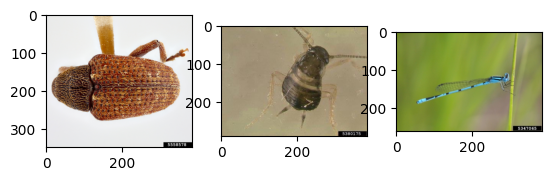

In [14]:
# Read the images to be classified
img1 = read_image('/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/test/beetles/5558578.jpg')
img2 = read_image('/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/test/cockroach/5380175.jpg')
img3 = read_image('/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/insects_data/test/dragonflies/5347065.jpg')

# Show the images
plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(img1.permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(img2.permute(1, 2, 0))
plt.subplot(1,3,3)
plt.imshow(img3.permute(1, 2, 0))

# Initialize the inference transforms for the ResNet18 model
preprocess = weights_resnet.transforms()
print(preprocess)

# Apply inference ResNet18 preprocessing transforms
img1_transformed = preprocess(img1)
img2_transformed = preprocess(img2)
img3_transformed = preprocess(img3)

# Change the dimensions to (1, C, H, W)
img1_batch = preprocess(img1_transformed).unsqueeze(0)
img2_batch = preprocess(img2_transformed).unsqueeze(0)
img3_batch = preprocess(img3_transformed).unsqueeze(0)

# Size of the different images
print('Size of the original image', img1.shape)
print('Size of the transformed image', img1_transformed.shape)
print('Size of the input to the pre-trained model', img1_batch.shape)
print('Size of the original image', img2.shape)
print('Size of the transformed image', img2_transformed.shape)
print('Size of the input to the pre-trained model', img2_batch.shape)
print('Size of the original image', img3.shape)
print('Size of the transformed image', img3_transformed.shape)
print('Size of the input to the pre-trained model', img3_batch.shape)

### **Classification with the pre-trained model**

Once the images have been preprocessed, they can be used as input to the pre-trained model.


---
### [EXERCISE 5]
---

In this example, we have classified the previous transformed images using the ResNet18 model. Note that the classes of the pre-trained model outputs can be found at `weights_resnet.meta["categories"]`.

1) Are the predictions correct? Is it adequate to use this pre-trained model in the current form for our image classification task?

Las imágenes originales son de insectos, y se han predicho mal las categorías.

2) In a new cell, modify the code below for using the pre-trained VGG16 model and answer again the previous questions.

En esta ocasión se predijo la categoría "damselfly" con alta fiabilidad, aunque para las otras dos imágenes la clasificación no fue buena, pero mejora al modelo anterior.


In [15]:
# ---------------------------------------------------
# Classification with the pre-trained ResNet18 model
# ---------------------------------------------------
# Set model to eval mode
model_resnet.eval()

# Use the model and print the predicted category
prediction = model_resnet(img1_batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights_resnet.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

# Use the model and print the predicted category
prediction = model_resnet(img2_batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights_resnet.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

# Use the model and print the predicted category
prediction = model_resnet(img3_batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights_resnet.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

matchstick: 55.9%
honeycomb: 17.7%
digital clock: 28.5%


In [16]:
# ---------------------------------------------------
# Classification with the pre-trained VGG16 model
# ---------------------------------------------------
from torchvision.models import vgg16, VGG16_Weights

# Initialize VGG16 model with the best available weights
weights_vgg = VGG16_Weights.DEFAULT
model_vgg = vgg16(weights=weights_vgg)

# Set model to eval mode
model_vgg.eval()

# Use the model and print the predicted category for each image
for img_batch in [img1_batch, img2_batch, img3_batch]:
    prediction = model_vgg(img_batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights_vgg.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.1f}%")


shopping basket: 65.9%
ground beetle: 17.7%
damselfly: 99.5%


---
## 5. TRANSFER LEARNING
---
The whole idea of **transfer learning** is to take an already well-performing model on a problem-space similar to ours and then customising it to our use case.
To perform transfer learning, we are going to carry out the following steps:

* Selection of the initial pre-trained model
* Use of the pre-trained model as feature extractor
* Fine-tuning

---
### 5.1. SELECTION OF THE INITIAL PRE-TRAINED MODEL
---

As in Section 4, we are going to work with the pre-trained ResNet18 model, that was initialized in Section 4.2.




---
### 5.2. USE OF THE PRE-TRAINED MODEL AS FEATURE EXTRACTOR
---

The pre-trained vision models are usually composed of two stages. The first one (convolutional part) acts as feature extractor, whereas the second part (fully connected part) acts as a classifier.

Therefore, as in this Section the pre-trained model is going to be used as **feature extractor**, we will freeze the weights for all the network except that of the final fully connected layers (classification head). These last fully connected layers are replaced with new ones with random weights and trained.





### **Examination of the structure of the classification head of the pre-trained model**

In the following code, we can examine the structure of the classification head of the ResNet18 model. In this case, the classification head is called `fc`.


---
### [EXERCISE 6]
---

1) Describe the structure of the classification head of the ResNet18 model.

- Tiene una capa lineal, típica en las redes neuronales para realizar tareas de clasificación.

- in_features=512 ,esto indica que la capa lineal toma un vector de 512 características como entrada. Estas 512 características son el resultado de todas las capas convolucionales y de pooling del modelo ResNet18, condensadas en una representación de características de alta dimensión.

- out_features=1000 el modelo tiene 1000 salidas, lo que corresponde al número de clases en el conjunto de datos ImageNet, para el cual el modelo ResNet18 original fue entrenado. Cada una de estas salidas representa la probabilidad de que la imagen de entrada pertenezca a una de las 1000 clases.

- bias=True, la capa incluye un término de sesgo, lo que es común en las capas lineales para permitir un ajuste más flexible del modelo.

In [17]:
# ---------------------------------------------------------------
# Exploration of the classification head of the ResNet18 model
# ---------------------------------------------------------------
# Resnet18
model_resnet = resnet18(weights=None)
print("resnet18\n", model_resnet.fc)

resnet18
 Linear(in_features=512, out_features=1000, bias=True)


### **Training of the new classification head and evaluation**

In this example, we are going to perform the following steps:

* First, we need to freeze all the network except the layers corresponding to the classification head. For that, we will set `requires_grad = False` in the convolutional part of the model to freeze the corresponding parameters in such a way that the gradients are not computed in `backward()` step of the training process.

* Second, we substitute the original classification part with a new classification head whose layer is going to be trained.

* Third, we train this new classification head.

* Finally, we evaluate the new model on the test set.


---
### [EXERCISE 7]
---

1) Complete the code below and train the model with 15 epochs by using the function `training_loop()` as in Lab Exercise 1.

2) In a new cell, perform the classification of the test set using the model obtained. Determine the loss and the accuracy achieved over it. You can use the function `eval_model()` as in Lab Exercise 1.


In [18]:
# ----------------------------------
# Training
# ----------------------------------
# Initialize ResNet18 model with the best available weights
# (currently alias for IMAGENET1K_V1)
weights_resnet = ResNet18_Weights.DEFAULT
model_conv_resnet = resnet18(weights=weights_resnet)

# Freeze the layers of the pre-trained model
for param in model_conv_resnet.parameters():
    param.requires_grad = False

# Add new classification head
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_resnet.fc.in_features
# Number of classes
num_classes = 3
model_conv_resnet.fc = nn.Linear(num_ftrs, num_classes)

# Training of classification layers
optimizer = optim.SGD(model_conv_resnet.fc.parameters(), lr=0.001, momentum=0.9)

# Entrenar el modelo
training_loop(
    model=model_conv_resnet,
    optimizer=optimizer,
    epochs=15,
    device=device
)

Got 129 / 450 correct (28.67)
Loss=1.28
Training: Epoch  0, Iteration 0, loss = 1.2778 acc = 28.67
Got 59 / 180 correct (32.78)
Loss=1.35
Validation: Epoch  0, Iteration 0, loss = 1.3464 acc = 32.78

Got 202 / 450 correct (44.89)
Loss=0.98
Training: Epoch  1, Iteration 0, loss = 0.9786 acc = 44.89
Got 71 / 180 correct (39.44)
Loss=1.12
Validation: Epoch  1, Iteration 0, loss = 1.1197 acc = 39.44

Got 349 / 450 correct (77.56)
Loss=0.66
Training: Epoch  2, Iteration 0, loss = 0.6595 acc = 77.56
Got 113 / 180 correct (62.78)
Loss=0.82
Validation: Epoch  2, Iteration 0, loss = 0.8233 acc = 62.78

Got 374 / 450 correct (83.11)
Loss=0.48
Training: Epoch  3, Iteration 0, loss = 0.4824 acc = 83.11
Got 129 / 180 correct (71.67)
Loss=0.65
Validation: Epoch  3, Iteration 0, loss = 0.6459 acc = 71.67

Got 370 / 450 correct (82.22)
Loss=0.41
Training: Epoch  4, Iteration 0, loss = 0.4102 acc = 82.22
Got 111 / 180 correct (61.67)
Loss=0.70
Validation: Epoch  4, Iteration 0, loss = 0.7018 acc = 61.6

In [19]:
# ----------------------------------
# Evaluation on the test set
# ----------------------------------
acc_test, loss_test = eval_model(
    loader=loader_test,
    model=model_conv_resnet,
    device=device
)
print(f"Test Accuracy: {acc_test*100:.2f}%, Test Loss: {loss_test:.4f}")

Got 165 / 180 correct (91.67)
Loss=0.23
Test Accuracy: 91.67%, Test Loss: 0.2259


---
### 5.3. FINE-TUNING
---

The previous model can be refined by **fine-tuning** it. For that, we are going to carry out the following steps:

* First, we copy the previous model (`model_conv_resnet`) to a new one (`model_ft_resnet`).

* Second, we unfreeze all the layers of the network `model_ft_resnet`. For that, we will set `requires_grad = True` in all the layers.

* Third, we train this new model.

* Finally, we evaluate this new model on the test set.


### **Fine-tuning and evaluation**

---
### [EXERCISE 8]
---

1) Complete the code below and train the new model with 10 epochs. As optimizer, use SGD with a lower learning rate (1e-4) and momentum = 0.9.

2) In a new cell, perform the classification of the test set using the model obtained. Determine the loss and the accuracy achieved over it.

      Got 172 / 180 correct (95.56)
      Loss=0.15
      Test Accuracy: 95.56%
      Test Loss: 0.1509

3) How is the performance compared with the results in Exercises 1 and 7?

Estos resultados demuestran claramente las ventajas del uso de modelos preentrenados y el fine-tuning en el deep learning, especialmente para mejorar la precisión y reducir la pérdida en tareas de clasificación específicas.

En el ejercicio1, entrenamiento desde cero:

      Got 161 / 180 correct (89.44)
      Loss=0.30
      Test Accuracy: 89.44%
      Test Loss: 0.3048

En el ejercicio7, modelo preentrenado:

      Got 165 / 180 correct (91.67)
      Loss=0.23
      Test Accuracy: 91.67%, Test Loss: 0.2259

En este ejercicio Fine-Tuning:

      Got 172 / 180 correct (95.56)
      Loss=0.15
      Test Accuracy: 95.56%
      Test Loss: 0.1509

      

In [20]:
# ----------------------------------
# Fine-tuning
# ----------------------------------
# Copy to a new model to be fine-tuned
model_ft_resnet = copy.deepcopy(model_conv_resnet)

# Unfreeze all the layers of the model
for param in model_ft_resnet.parameters():
    param.requires_grad = True

# Fine-tuning of the model
optimizer = optim.SGD(model_ft_resnet.parameters(), lr=1e-4, momentum=0.9)

# Entrenar el modelo
training_loop(
    model=model_ft_resnet,
    optimizer=optimizer,
    epochs=10,
    device=device
)

Got 436 / 450 correct (96.89)
Loss=0.15
Training: Epoch  0, Iteration 0, loss = 0.1506 acc = 96.89
Got 158 / 180 correct (87.78)
Loss=0.32
Validation: Epoch  0, Iteration 0, loss = 0.3154 acc = 87.78

Got 433 / 450 correct (96.22)
Loss=0.16
Training: Epoch  1, Iteration 0, loss = 0.1556 acc = 96.22
Got 160 / 180 correct (88.89)
Loss=0.29
Validation: Epoch  1, Iteration 0, loss = 0.2950 acc = 88.89

Got 438 / 450 correct (97.33)
Loss=0.18
Training: Epoch  2, Iteration 0, loss = 0.1788 acc = 97.33
Got 157 / 180 correct (87.22)
Loss=0.31
Validation: Epoch  2, Iteration 0, loss = 0.3101 acc = 87.22

Got 438 / 450 correct (97.33)
Loss=0.12
Training: Epoch  3, Iteration 0, loss = 0.1250 acc = 97.33
Got 159 / 180 correct (88.33)
Loss=0.31
Validation: Epoch  3, Iteration 0, loss = 0.3119 acc = 88.33

Got 437 / 450 correct (97.11)
Loss=0.22
Training: Epoch  4, Iteration 0, loss = 0.2202 acc = 97.11
Got 159 / 180 correct (88.33)
Loss=0.33
Validation: Epoch  4, Iteration 0, loss = 0.3326 acc = 88

In [21]:
# ----------------------------------
# Evaluation on the test set
# ----------------------------------
acc_test, loss_test = eval_model(
    loader=loader_test,  # Asegúrate de que 'loader_test' esté definido y sea tu DataLoader de prueba
    model=model_ft_resnet,
    device=device
)
print(f"Test Accuracy: {acc_test*100:.2f}%, Test Loss: {loss_test:.4f}")


Got 172 / 180 correct (95.56)
Loss=0.15
Test Accuracy: 95.56%, Test Loss: 0.1509


---
---
# **PART 2. EXPLAINABLE ARTIFICIAL INTELLIGENCE (XAI)**

## **GRAD-CAM AND SHAP**

In the second part of this Lab Exercise, we will try to explain the predictions made by a deep-learning model for three images taken from the test set of our dataset. These images are contained in the `test_xai_dataset` already loaded in Section 2 by means of the loader *loader_test_xai*.

In particular, we will use these two different approaches:

* Grad-CAM
* SHAP (DeepExplainer)
---
---

### Prediction of the images

First of all, we are going to compute the predictions of the three images by using a previouly trained model with the architecture `Simple_CNN` defined in Section 3. This model is called `"simpleCNN_20epochs.pt"` and it is available in Aula Global.

Execute the following cell for obtaining the predictions.

In [22]:
# -----------------------
# Classification
# -----------------------
# Load the model
model_xai = torch.load("/content/drive/MyDrive/Colab Notebooks/ATVIAV/LabSession3/Práctica 3 - Material-20231112/simpleCNN_20epochs.pt", map_location=torch.device(device))
#print(model_xai)

# Load the images
batch = next(iter(loader_test_xai))
images_xai, labels_xai = batch

# Transform image for visualization
images_vis = images_xai.numpy()
images_vis = np.float32(images_vis) / 255
images_vis = np.transpose(images_vis, (0, 2, 3, 1))

# Set model and image to device
model_xai.to(device)
images_xai_input = images_xai.to(device)

# Set model to evaluation mode
model_xai.eval()

# Compute prediction
with torch.no_grad():
  outputs = model_xai(images_xai_input)
  _, prediction = torch.max(outputs, 1)

# Print GT and predictions
for img in range(len(images_xai_input)):
  print ('Image', img)
  print('Ground Truth:', class_names[labels_xai[img]], '->', 'Prediction:', class_names[prediction[img]])

Image 0
Ground Truth: beetles -> Prediction: beetles
Image 1
Ground Truth: cockroach -> Prediction: cockroach
Image 2
Ground Truth: dragonflies -> Prediction: dragonflies


---
## 6. GRAD-CAM
---
Now, we are going to apply the **Grad-CAM** method for explaining the predictions of the images.

Note that as Grad-CAM is class-specific, there is an activation map for each class. For that, for a particular image, four plots are obtained. The first one is the original image, whereas the remaining ones contain the activation map for each class overlayed on the original image.




---
### [EXERCISE 9]
---

1) Choose one of the test images and the activation map corresponding to the prediction made by the model. From this activation map, try to explain the decision of the model for this particular image.

-En la primera imagen, el mapa de calor para la clase "beetles" muestra una activación fuerte sobre todo el cuerpo del escarabajo, lo que parece indicar que el modelo está correctamente identificando las características relevantes del insecto. Por otro lado para las clases "cockroach" y "dragonflies", hay muy poca o ninguna activación, lo que indica que el modelo no está confundiendo las características de estas clases con las del escarabajo.

-Mirando la segunda imagen, se observa el mapa de calor para la clase "cockroach" muestra una activación significativa sobre la cucaracha, particularmente en su sección media y patas, que son características distintivas. También muestra una activación alta para el escarabajo, lo que puede hacer fallar al modelo.

-En la tercera imagen, para la clase "dragonflies" destaca principalmente las alas y la cola de la libélula, que son características distintivas de estas especies.
Hay algo de activación para las otras dos clases, pero es mucho menos significativa en comparación con la activación para "dragonflies", sugiriendo que el modelo parece estar  seguro de esta clasificación.


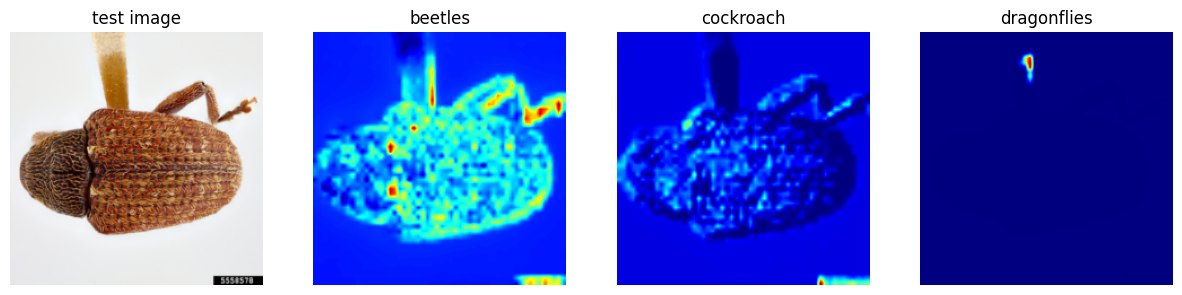

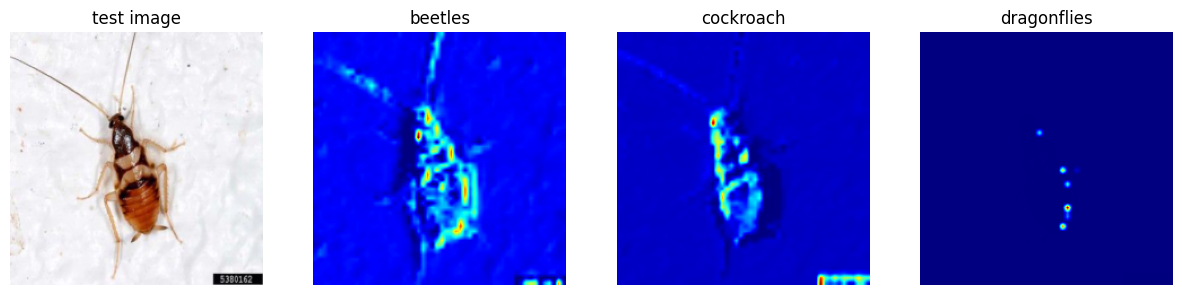

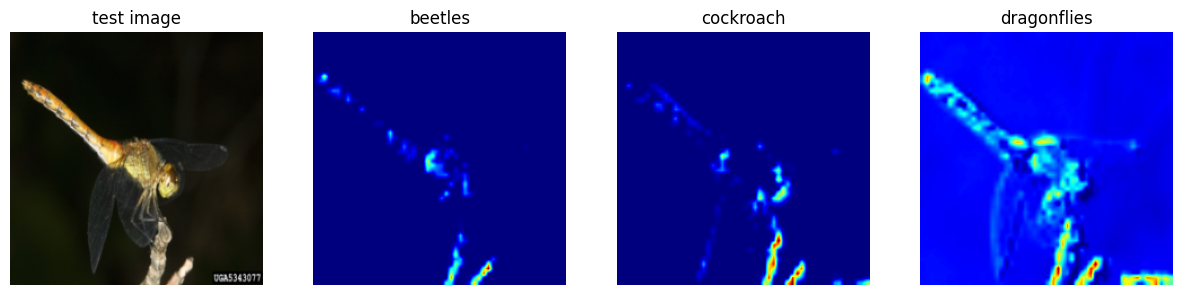

In [23]:
# -----------------------
# Grad-CAM
# -----------------------
# Set the layer whose output is going to be explained. In this case,
# it is the last convolutional layer of the model
target_layers = [model_xai.conv_sec[-1]]

# Construct the CAM object once, and then re-use it on many images:
if torch.cuda.is_available():
  cam = GradCAM(model=model_xai, target_layers=target_layers, use_cuda=True)
else:
  cam = GradCAM(model=model_xai, target_layers=target_layers, use_cuda=False)

# Structure for keeping the activation maps of all the classes for an image
num_classes = len(class_names)
vis_global = np.zeros((num_classes, images_vis.shape[1], images_vis.shape[2], images_vis.shape[3]), dtype=int)

# Visualize the Grad-CAM over the image
for img in range(len(images_xai_input)):

  # Visualize the Grad-CAM of the current image for each of the classes
  for c in range(num_classes):
    targets = [ClassifierOutputTarget(c)]

    img_xai = images_xai_input[img:img+1,:]
    img_vis = images_vis[img, :]

    # Compute the Grad-CAM activation map for class "target" (class "c")
    grayscale_cam = cam(input_tensor=img_xai, targets=targets)

    # In this case, grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    # Visualize the Grad-CAM over the image for class "target" (class "c")
    visualization = show_cam_on_image(img_vis, grayscale_cam, use_rgb=True)
    vis_global[c,:,:,:] = visualization

  # Plot the visualization
  fig, ax = plt.subplots(1, 4, figsize=(15, 5))

  ax[0].imshow(img_vis*255)
  ax[0].axis('off')
  ax[0].set_title('test image')
  for c in range(num_classes):
    ax[c+1].imshow(vis_global[c,:,:,:])
    ax[c+1].axis('off')
    ax[c+1].set_title(class_names[c])

---
## 7. SHAP
---
Now, we are going to use the **SHAP** method in the three test images.

Shapley values provide an additive measure of feature importance. In the context of an image, each pixel is treated as a feature, therefore, Shapley value can be used to determine the pixel level importance in classifying images.

The SHAP plot consists of the original image followed by three versions of itself, corresponding to the three classes in the dataset. In these three last images, pixels colored deep blue are those which push the model away from predicting that the image belongs to that particular class while pixels colored bright red are those which strongly indicate that the image probably belongs to the class in question; white coloration show that no importance was placed on those pixels by the model.






---
### [EXERCISE 10]
---

1) Choose one of the test images. By observing the corresponding SHAP plots, try to explain the decision of the model for this particular image.

- En la primera imagen los píxeles rojos se concentran en el cuerpo del escarabajo, lo que sugiere que estas características específicas aumentan la confianza del modelo en su predicción de que la imagen es un escarabajo. Es probable que el modelo esté reconociendo texturas o patrones de color típicos de los escarabajos.
No hay muchos píxeles azules oscuros, lo que indica que no hay muchas características que disuadan al modelo de esta clasificación.

- En la segunda imagen los píxeles rojos indican las áreas que el modelo asocia fuertemente con una cucaracha, probablemente centrados en las patas y el cuerpo segmentado del insecto.
Las áreas azules pueden representar fondos o regiones de la imagen que no son comunes en las imágenes de cucarachas que el modelo ha aprendido.

- En la tercera imagen los píxeles rojos destacan las alas y el cuerpo alargado, que son características distintivas de una libélula y contribuyen positivamente a la clasificación del modelo.El fondo no contribuye a la decisión del modelo, como se muestra por la ausencia de píxeles rojos o azules significativos en esas áreas.

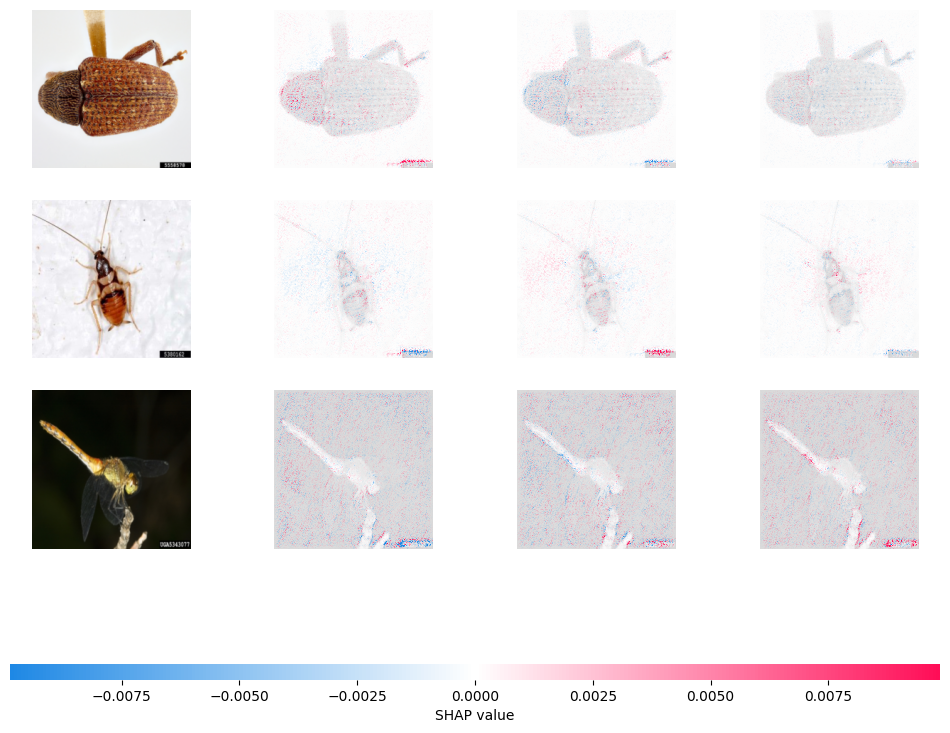

In [24]:
# -----------------------
# SHAP
# -----------------------
# Load the data. The images of the validation set will be used as background
# images. These images are needed for building the DeepExplainer.
# The images to be explained are contained in batch_test_xai
batch_background = next(iter(loader_val))
batch_test_xai = next(iter(loader_test_xai))

background, labels_background = batch_background
images_xai, labels_xai = batch_test_xai

# Set images and model to device
background = background.to(device)
images_xai_input = images_xai.to(device)
model_xai.to(device)

# Build the DeepExplainer
e = shap.DeepExplainer(model_xai, background)

# Compute the SHAP values
shap_values = e.shap_values(images_xai_input)

# Plot the feature attributions
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
images_xai_input_numpy = np.swapaxes(np.swapaxes(images_xai_input.detach().cpu().numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy,images_xai_input_numpy)